# Chapter 5

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 5.1 Spurious association

In [5]:
# load waffle data
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# standardise variables
def standardise(data):
    return (data - data.mean()) / data.std()


waffle["divorce"] = standardise(waffle["Divorce"])
waffle["marriage"] = standardise(waffle["Marriage"])
waffle["age"] = standardise(waffle["MedianAgeMarriage"])

First build a model for marriage rate based on age

In [6]:
n_draw = 100

with pm.Model() as m5_1:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # data
    age = pm.MutableData("age", waffle.age, dims="obs")
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_age * age, dims="obs")
    
    # likelihood
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="obs")
    
    # sample prior
    trace_5_1 = pm.sample_prior_predictive(samples=n_draw, random_seed=RANDOM_SEED)

Sampling: [alpha, beta_age, divorce, sigma]


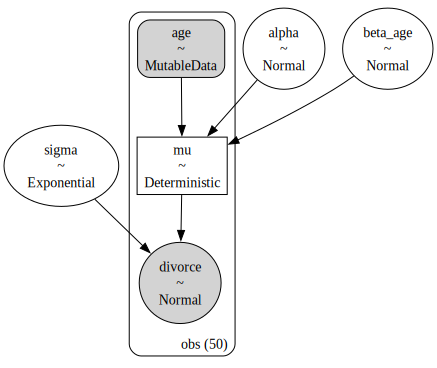

In [7]:
m5_1.to_graphviz()

Now we plot some plausible regression lines

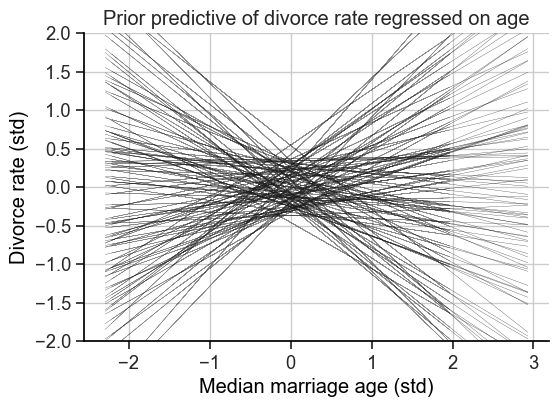

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

for draw in range(n_draw):
    ax.plot(
        trace_5_1.constant_data.age,
        trace_5_1.prior.mu.sel(chain=0, draw=draw),
        color="k",
        lw=0.2,
        alpha=0.5,
    )

ax.set(
    ylim=[-2, 2],
    xlabel="Median marriage age (std)",
    ylabel="Divorce rate (std)",
    title="Prior predictive of divorce rate regressed on age",
);

Now hit the sample button

In [9]:
with m5_1:
    trace_5_1 = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [11]:
az.summary(
    trace_5_1,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.10,-0.16,0.16
beta_age,-0.57,0.12,-0.75,-0.38
sigma,0.83,0.09,0.69,0.95


Also want to plot against the actual data.

In [12]:
def plot_posterior_compatibility_interval(trace, predictor, ax=None):
    # get the posterior data
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=0.89)
    mu_plot_data = pd.DataFrame(
        {
            predictor: trace.constant_data[predictor],
            "mean": trace.posterior.mu.mean(dim=["chain", "draw"]),
            "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
            "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values(predictor)
    
    # plot
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot true data
    sns.scatterplot(
        x=trace.constant_data[predictor],
        y=trace.observed_data.divorce,
        ax=ax
    )

    # plot the mean at each weight
    ax.plot(mu_plot_data[predictor], mu_plot_data["mean"], color="k")

    ax.fill_between(
        mu_plot_data[predictor],
        mu_plot_data["hdi_lower"],
        mu_plot_data["hdi_higher"],
        color="k",
        alpha=0.3,
    )

    ax.set(
        xlabel=predictor,
        ylabel="Divorce rate (std)",
        title="Posterior compatibility interval"
    )

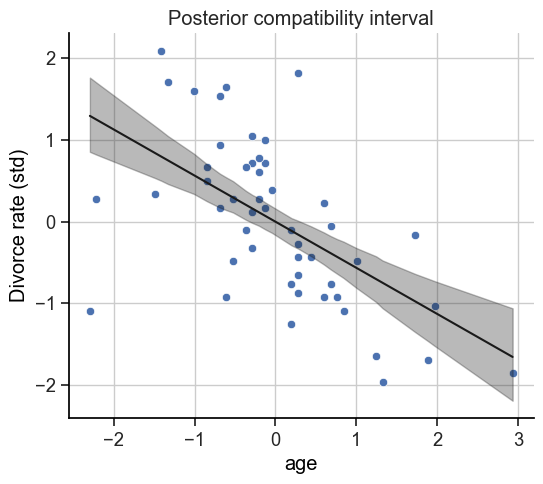

In [13]:
plot_posterior_compatibility_interval(trace_5_1, "age");

We build a similar model 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


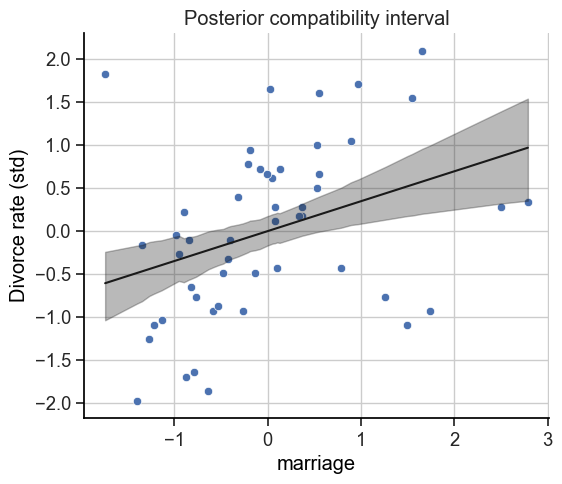

In [14]:
with pm.Model() as m5_2:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # data
    marriage = pm.MutableData("marriage", waffle.marriage, dims="obs")
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_marriage * marriage, dims="obs")
    
    # likelihood
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="obs")
    
    # sample
    trace_5_2 = pm.sample(draws=1000, random_seed=RANDOM_SEED)

plot_posterior_compatibility_interval(trace_5_2, "marriage");

### 5.1.4 Approximating the posterior

Now we create a multiple regression model

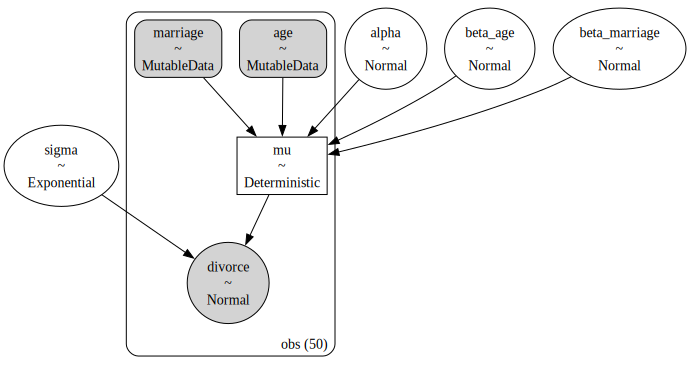

In [15]:
with pm.Model() as m5_3:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # data
    age = pm.MutableData("age", waffle.age, dims="obs")
    marriage = pm.MutableData("marriage", waffle.marriage, dims="obs")
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_age * age + beta_marriage * marriage, dims="obs")
    
    # likelihood
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="obs")


m5_3.to_graphviz()

Now let's sample

In [16]:
with m5_3:
    trace_5_3 = pm.sample(draws=1000)

az.summary(
    trace_5_3,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.10,-0.15,0.17
beta_age,-0.61,0.16,-0.84,-0.34
beta_marriage,-0.06,0.16,-0.31,0.21
sigma,0.83,0.08,0.70,0.97


Plot the feature coefficients for the different models.

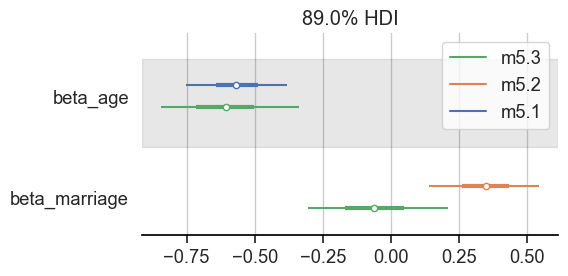

In [33]:
az.plot_forest(
    [trace_5_1, trace_5_2, trace_5_3],
    model_names=["m5.1", "m5.2", "m5.3"],
    var_names="beta",
    filter_vars="regex",
    hdi_prob=0.89,
    combined=True,
    figsize=(6, 3)
)
plt.tight_layout();

### 5.1.5 Plotting multivariate posteriors

#### 5.1.5.1 Predictor residual plots

First define a model regression marriage rate and median marriage age:

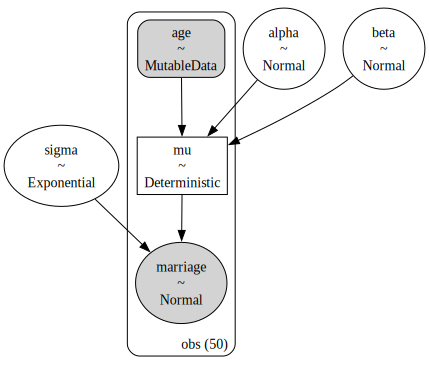

In [41]:
with pm.Model() as m5_4:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # data
    age = pm.MutableData("age", waffle.age, dims="obs")
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta * age, dims="obs")
    
    # likelihood
    marriage = pm.Normal("marriage", mu=mu, sigma=sigma, observed=waffle.marriage, dims="obs")


m5_4.to_graphviz()

Now sample and plot residuals.

In [42]:
with m5_4:
    trace_5_4 = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Get mean

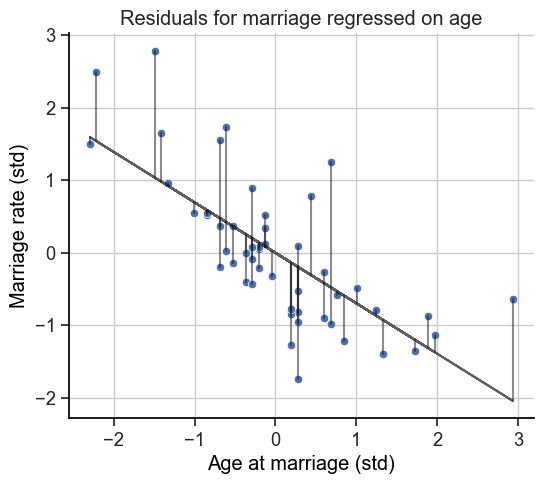

In [79]:
# plot
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(
    x=trace_5_4.constant_data.age,
    y=trace_5_4.observed_data.marriage,
    ax=ax
)

# plot the mean at each weight
ax.plot(
    trace_5_4.constant_data.age,
    trace_5_4.posterior.mu.mean(dim=["chain", "draw"]),
    color="k",
    alpha=0.7,
)

# plot lines from mu to observed value
ax.plot(
    (trace_5_4.constant_data.age, trace_5_4.constant_data.age),
    (
        trace_5_4.posterior.mu.mean(dim=["chain", "draw"]),
        trace_5_4.observed_data.marriage
    ),
    color="k",
    alpha=0.5
)

ax.set(
    xlabel="Age at marriage (std)",
    ylabel="Marriage rate (std)",
    title="Residuals for marriage regressed on age"
);

Now we regress divorce rate on the residuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


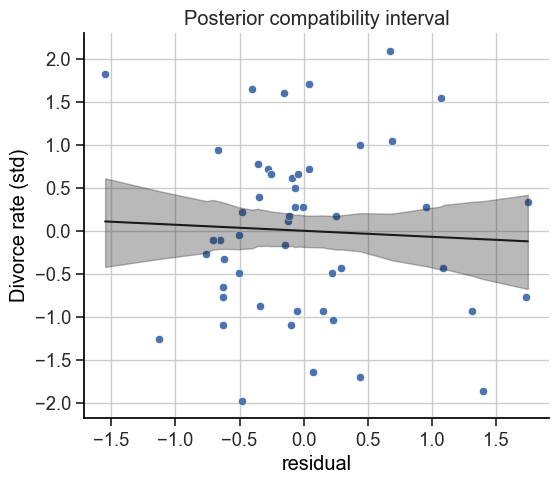

In [81]:
# get mean of mu for all data points
mu_mean = trace_5_4.posterior.mu.mean(dim=["chain", "draw"])
residuals = trace_5_4.observed_data.marriage - mu_mean

with pm.Model() as m5_4a:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # data
    residual = pm.MutableData("residual", residuals, dims="obs")
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta * residual, dims="obs")
    
    # likelihood
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="obs")

    # sample
    trace_5_4a = pm.sample(draws=1000, random_seed=RANDOM_SEED)

plot_posterior_compatibility_interval(trace_5_4a, "residual");

This supports the hypothesis that divorce rate is conditionally independent of marriage rate given marriage age.

#### 5.1.5.3 Counterfactual plots

We generate separate models for the influence of A and M on D and for the influence of A on M.

In [92]:
with pm.Model() as m5_3a:
    # data
    age = pm.MutableData("age", waffle.age, dims="obs")
    marriage = pm.MutableData("marriage", waffle.marriage, dims="obs")
    
    # A -> D <- M
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_A = pm.Normal("beta_A", mu=0, sigma=0.5)
    beta_M = pm.Normal("beta_M", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_A * age + beta_M * marriage, dims="obs")
    
    # likelihood
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="obs")
    
    # A -> M
    # priors
    alpha_M = pm.Normal("alpha_M", mu=0, sigma=0.2)
    beta_AM = pm.Normal("beta_AM", mu=0, sigma=0.5)
    sigma_M = pm.Exponential("sigma_M", lam=1)
    
    # linear model
    mu_M = pm.Deterministic("mu_M", alpha_M + beta_AM * age, dims="obs")
    
    # likelihood
    marriage_obs = pm.Normal("marriage_obs", mu=mu_M, sigma=sigma_M, observed=waffle.marriage, dims="obs")
    
    # sample
    trace_5_3a = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_M, sigma, alpha_M, beta_AM, sigma_M]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


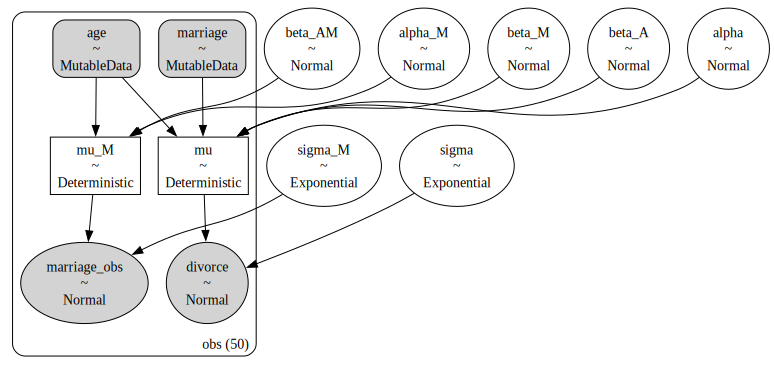

In [93]:
m5_3a.to_graphviz()

Does it matter that it doesn't 'know' that `marriage` and `marriage_obs` are different?

We can sample posterior predictive for 'made up' values of age.

In [97]:
age_seq = np.linspace(-2, 2, 30)

with m5_3a:
    pm.set_data({"age": age_seq})
    trace_5_3a = pm.sample_posterior_predictive(
        trace_5_3a,
        var_names=["mu_M", "marriage_obs"],
        extend_inferencedata=True,
        predictions=True,
    )

Sampling: [marriage_obs]


In [98]:
trace_5_3a

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

How can I feed these values back into the model to predict divorce? The needs to have the same number of observations as in age.

It takes posterior samples. We want it to, for each age value, sample each of the posteriors *and one of the posterior marriage values for that age* and then simulate a mu (and divorce) value.

How can I force it to do this? Surely I need to tell it that marriage should now be treated as a distribution, not data.

I can probably do this manually.

In [ ]:
trace_5_3a.predictions.marriage_obs

In [ ]:
with m5_3a:
    pm.set_data({"marriage": post_pred_5_3a.predictions
    post_pred_5_3b

Now do the same for divorce with the simulated values?

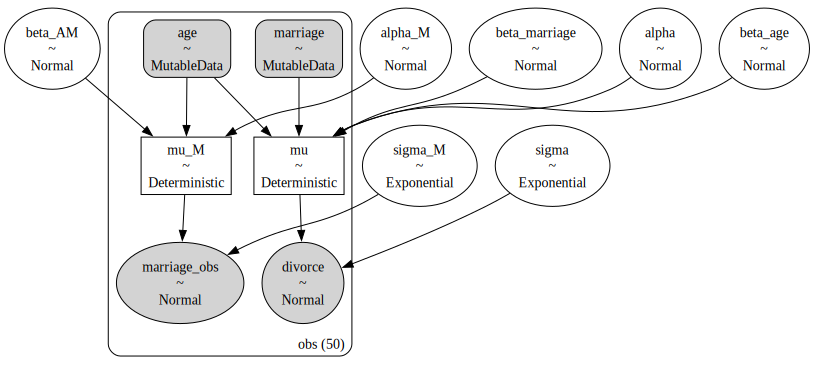

In [86]:
m5_3a.to_graphviz()

In [87]:
with pm.Model() as pm_model:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * waffle.age + bM * waffle.marriage)
    divorce = pm.Normal("divorce", mu, sigma, observed=waffle.divorce.values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * waffle.age)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=waffle.marriage.values)

    pm_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [89]:
pm_model

   sigma ~ Exponential(f())
      bA ~ Normal(0, 0.5)
      bM ~ Normal(0, 0.5)
       a ~ Normal(0, 0.2)
 sigma_m ~ Exponential(f())
     bAM ~ Normal(0, 0.5)
      aM ~ Normal(0, 0.2)
      mu ~ Deterministic(f(bM, a, bA))
    mu_m ~ Deterministic(f(aM, bAM))
 divorce ~ Normal(mu, sigma)
marriage ~ Normal(mu_m, sigma_m)

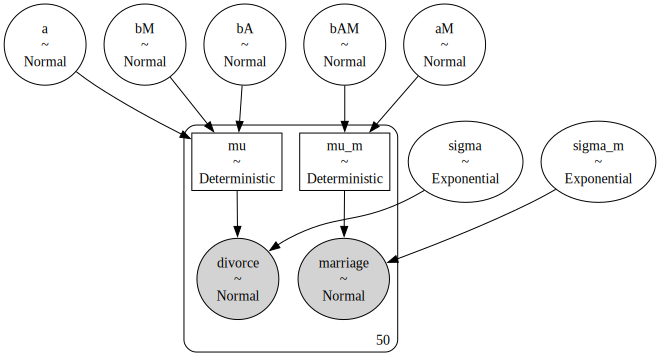

In [91]:
pm_model.to_graphviz()